Importing Libraries

In [54]:
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Defining Transformations:
Normalizing the image to make training stable as raw image pixels are in range(0-255)

In [56]:
# For Training: Augmentation (helps to prevent overfitting) + Normalization
trainTransforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), # Convert to Tensor (Pytorch uses tensor to store data for model.)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For test and validation:
valTransforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Loding the Dataset

In [57]:
# change the root to your respective dataset path
dataset = datasets.ImageFolder(root="D:/cell_images", transform=trainTransforms)

Spliting the data into Train and Validation (80%-20%)

In [58]:
trainSize = int(0.7*len(dataset))
valSize = int(0.15*len(dataset))
testSize = len(dataset)-trainSize-valSize

trainDataset, valDataset, testDataset = random_split(dataset, [trainSize, valSize, testSize])

trainDataset.dataset.transform = trainTransforms
valDataset.dataset.transform = valTransforms
testDataset.dataset.transform = valTransforms

Creating a DataLoaders

In [59]:
trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=20, shuffle=False)

dataLoaders = {
    'train' : trainLoader,
    'valid' : valLoader,
    'test' : testLoader
}

Inverse transform to undo the normalization to make image looks natural again when plotted with matplotlib

In [60]:
invTransform = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],std=[ 1/0.229, 1/0.224, 1/0.225 ]), 
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ], std=[ 1., 1., 1. ])
    ])

# this functions show image tensor
def showImg(image):
    image = invTransform(image)
    image = image.numpy()
    image = np.transpose(image, (1,2,0)) # Rearranging the dimesion from [C,H,W] to [H,W,C]
    
    plt.imshow(image)
    plt.axis('off')

Ploting the image with matplotlib

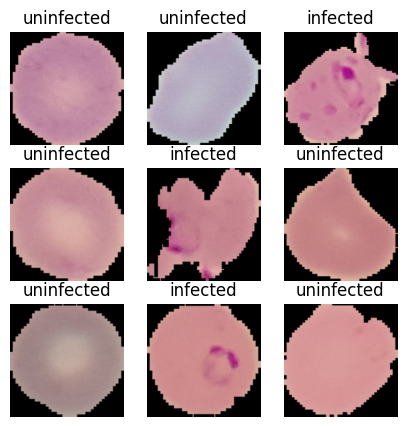

In [61]:
classes=['infected', 'uninfected']

# Getting a batch of training data
dataiter = iter(trainLoader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(5,5))

# Displaying 9 images
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    showImg(images[idx])
    ax.set_title(classes[labels[idx].item()])

Defining a CNN architecture

In [62]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        # Used to extract features from the image and the output is a 3d feature map
        self.conv = nn.Sequential(
            nn.Conv2d(3,16,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # It take those extracted fetures and decide what class the image belongs to. It performs classification based on the features learned by convolutional layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*28*28, 500),
            nn.ReLU(),
            nn.Dropout(0.2), # It randomly sets 20% of neurons to 0 to prevent overfitting
            nn.Linear(500, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 2)
        )
    
    # define how data flows through the network
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

modelScratch = net()
modelScratch.to(device)

net(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=50176, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=100, out_features=2, bias=True)
  )
)

Defining a loss function

In [63]:
criterionScratch = nn.CrossEntropyLoss()

optimizerScratch = optim.Adam(modelScratch.parameters(), lr=0.001)

Training the model

In [64]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.inf 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss as follows
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        # validate the model #
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

Testing the model

In [65]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
            
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    return y, y_hat

Test Loss: 0.694506


Test Accuracy: 48% (2001/4135)


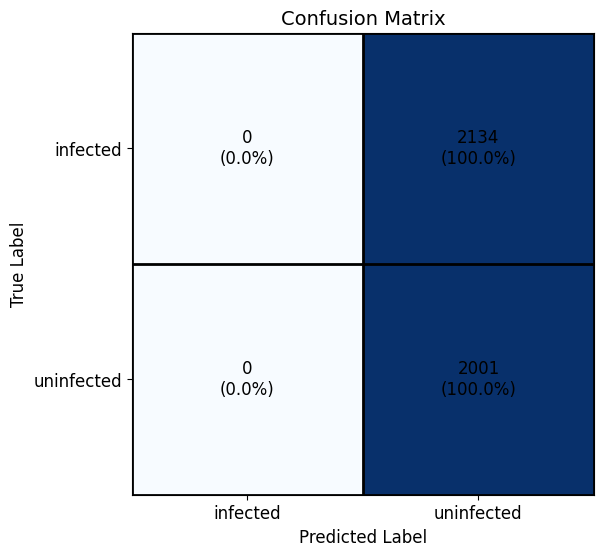

In [66]:
# Get predictions
y_true, y_pred = test(dataLoaders, modelScratch, criterionScratch, device)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
classes = ['infected', 'uninfected']

# Plot manually
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)

# Show counts and percentages inside cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i,j]}\n({cm_percent[i,j]:.1f}%)",
                ha="center", va="center", color="black", fontsize=12)

# Set tick labels properly
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=12)
ax.set_yticklabels(classes, fontsize=12)

# Labels, title
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Add borders between cells
ax.set_xticks(np.arange(len(classes)+1)-0.5, minor=True)
ax.set_yticks(np.arange(len(classes)+1)-0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

plt.show()